### Clustering

In [1]:
# Importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture

from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
conflict = pd.read_csv('data/conflict-econ-tor.csv')

In [3]:
conflict.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km
0,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Egypt),unknown,3,unknown,unknown,0,30,Northern Africa,Egypt,Cairo,Al Maadi,unknown,Cairo-Al Maadi,29.9667,31.2500,1,0,1578503454,564,56,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0
1,2017-01-01,2017,Battles,Armed clash,Military Forces of Iraq (2014-2018) Popular Mo...,unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Anbar,Anah,unknown,Aradi as Sakrah,34.1915,42.0313,3,6,1567462133,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0
2,2017-01-01,2017,Explosions/Remote violence,Air/drone strike,Military Forces of Iraq (2014-2018),unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Ninewa,Mosul,unknown,Mosul,36.3350,43.1189,1,20,1572403769,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0
3,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Islamic State (Iraq),unknown,2,Civilians (Iraq),unknown,7,27,Middle East,Iraq,Najaf,Najaf,unknown,Najaf,32.0259,44.3462,2,6,1572403770,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0
4,2017-01-01,2017,Battles,Armed clash,Islamic State (Iraq),unknown,2,Police Forces of Iraq (2014-2018),unknown,1,12,Middle East,Iraq,Najaf,Manathera,unknown,Al Mishkhab,31.8044,44.4893,1,0,1572403770,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0


In [4]:
lat_long = conflict[['latitude', 'longitude']]
coordinates = lat_long.values

In [5]:
# Clusters with 3km radius
# kms_per_radian = 6371.1
# epsilon = 3 / kms_per_radian
# db_3km = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))
# conflict['db_3_clusters'] = db_3km.labels_
# num_clusters = len(set(db_3km.labels_))
# # clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])
# print(f"Number of clusters: {num_clusters}")

In [6]:
# counts = np.bincount(cluster_labels[cluster_labels>=0])
# np.sort(counts)

In [7]:
kms_per_radian = 6371.1
epsilon = 3 / kms_per_radian

optics = OPTICS(min_samples=5, max_eps=epsilon, metric='haversine').fit(np.radians(coordinates))
conflict['optics_clusters'] = optics.labels_
num_clusters = len(set(optics.labels_))

print(f"Number of clusters: {num_clusters}")

Number of clusters: 2279


In [8]:
optics_labels = optics.labels_
clusters = pd.Series([coordinates[optics_labels == n] for n in range(num_clusters)])

In [40]:
clusters.drop(2278, inplace=True)

In [41]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [45]:
lats, lons = zip(*centermost_points)
cluster_coords = pd.DataFrame({'cluster_lat':lats, 'cluster_lons':lons})

In [46]:
cluster_coords.to_csv('data/optics-cluster-coords.csv', index=False)

In [21]:
# def get_centermost_point(cluster):
#     centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
#     centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
#     return tuple(centermost_point)

# centermost_points = clusters.map(get_centermost_point)

In [17]:
# lats, lons = zip(*centermost_points)
# cluster_points = pd.DataFrame({'cluster_lat':lats, 'cluster_lon':lons })

In [69]:
gmm = GaussianMixture(n_components=5)

In [70]:
gmm.fit(conflict['optics_clusters'].to_numpy().reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [71]:
preds = gmm.predict_proba(conflict['optics_clusters'].to_numpy().reshape(-1, 1))

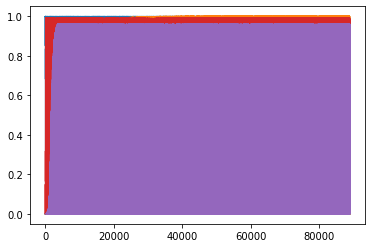

In [73]:
plt.plot(preds);